# Customer Segmentation with K-means

Data source: [link text](https://archive.ics.uci.edu/dataset/352/online+retail)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## Get data

In [2]:
! pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
online_retail = fetch_ucirepo(id=352)

# data (as pandas dataframes)
X = online_retail.data.features
y = online_retail.data.targets

# metadata
print(online_retail.metadata)

# variable information
print(online_retail.variables)

{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

## Data

In [4]:
cp = X.copy()

In [5]:
cp.head()

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Preprocessing

In [6]:
cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Description  540455 non-null  object 
 1   Quantity     541909 non-null  int64  
 2   InvoiceDate  541909 non-null  object 
 3   UnitPrice    541909 non-null  float64
 4   CustomerID   406829 non-null  float64
 5   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 24.8+ MB


In [7]:
cp.select_dtypes(include=['number']).describe()


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Data contains -Ve values.

In [8]:
cp = cp.drop(cp[cp.Quantity < 0].index)
cp = cp.drop(cp[cp.UnitPrice < 0].index)

In [9]:
cp.select_dtypes(include=['number']).describe()

,Quantity,UnitPrice,CustomerID
count,531283.000000,531283.000000,397924.000000
mean,10.655299,3.898954,15294.315171
std,156.830617,35.876279,1713.169877
min,1.000000,0.000000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


In [10]:
cp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 531283 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Description  530691 non-null  object 
 1   Quantity     531283 non-null  int64  
 2   InvoiceDate  531283 non-null  object 
 3   UnitPrice    531283 non-null  float64
 4   CustomerID   397924 non-null  float64
 5   Country      531283 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 28.4+ MB


In [11]:
cp['CustomerID'] = cp['CustomerID'].astype('Int64')
cp['InvoiceDate'] = pd.to_datetime(cp['InvoiceDate'])
cp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 531283 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Description  530691 non-null  object        
 1   Quantity     531283 non-null  int64         
 2   InvoiceDate  531283 non-null  datetime64[ns]
 3   UnitPrice    531283 non-null  float64       
 4   CustomerID   397924 non-null  Int64         
 5   Country      531283 non-null  object        
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 28.9+ MB


In [12]:
cp.isna().sum()

,0
Description,592
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,133359
Country,0


In [13]:

cp.dropna(inplace=True)
cp.isna().sum()


,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [14]:
def preprocess_data(df):
  """
  Preprocess the data by removing negative Quantity and UnitPrice,
  converting CustomerID to Int64, and converting InvoiceDate to datetime.

  Args:
    df: The input pandas DataFrame.

  Returns:
    A preprocessed pandas DataFrame.
  """
  cp = df.copy()

  # Remove rows with negative Quantity or UnitPrice
  cp = cp.drop(cp[cp.Quantity < 0].index)
  cp = cp.drop(cp[cp.UnitPrice < 0].index)

  # Convert CustomerID to Int64
  cp['CustomerID'] = cp['CustomerID'].astype('Int64')

  # Convert InvoiceDate to datetime
  cp['InvoiceDate'] = pd.to_datetime(cp['InvoiceDate'])

  # Fill NaN CustomerID with random existing CustomerID
  customer_ids = cp['CustomerID'].dropna().astype(int).unique()
  cp['CustomerID'].fillna(np.random.choice(customer_ids), inplace=True)

  return cp


## Strategy
We will use **RFM (Recency, Frequency, Monetary)** analysis and **K-Means** clustering to do segmentation.

  1- Find RFM

  2- Apply K-Means on RFM data.

  3- Validate findings

  4- Final Results.

## Finding RFM

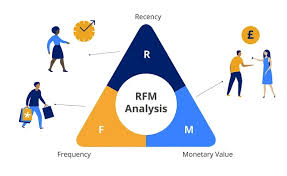






In [15]:
df = cp.copy()

# Calculate Recency
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # Convert InvoiceDate to datetime if it's not already
latest_date = df['InvoiceDate'].max()
rfm = df.groupby('CustomerID')['InvoiceDate'].max().apply(lambda x: (latest_date - x).days).reset_index(name='Recency')

# Calculate Frequency
frequency = df.groupby('CustomerID')['InvoiceDate'].nunique().reset_index(name='Frequency')
rfm = pd.merge(rfm, frequency, on='CustomerID')

# Calculate Monetary Value
df['TotalValue'] = df['UnitPrice'] * df['Quantity']
monetary = df.groupby('CustomerID')['TotalValue'].sum().reset_index(name='MonetaryValue')
rfm = pd.merge(rfm, monetary, on='CustomerID')

# Now you have the RFM DataFrame 'rfm' with Recency, Frequency, and MonetaryValue for each customer.

rfm.head()


,CustomerID,Recency,Frequency,MonetaryValue
0,12346,325,1,77183.60
1,12347,1,7,4310.00
2,12348,74,4,1797.24
3,12349,18,1,1757.55
4,12350,309,1,334.40


In [16]:
# Define a function to map RFM values onto a 1-5 scale
def map_rfm_to_scale(x, metric):
  if metric == 'Recency':
    if x <= rfm['Recency'].quantile(0.20):
      return 5
    elif x <= rfm['Recency'].quantile(0.40):
      return 4
    elif x <= rfm['Recency'].quantile(0.60):
      return 3
    elif x <= rfm['Recency'].quantile(0.80):
      return 2
    else:
      return 1
  else:  # Frequency and MonetaryValue
    if x <= rfm[metric].quantile(0.20):
      return 1
    elif x <= rfm[metric].quantile(0.40):
      return 2
    elif x <= rfm[metric].quantile(0.60):
      return 3
    elif x <= rfm[metric].quantile(0.80):
      return 4
    else:
      return 5


# Apply the function to each RFM metric
rfm['R'] = rfm['Recency'].apply(lambda x: map_rfm_to_scale(x, 'Recency'))
rfm['F'] = rfm['Frequency'].apply(lambda x: map_rfm_to_scale(x, 'Frequency'))
rfm['M'] = rfm['MonetaryValue'].apply(lambda x: map_rfm_to_scale(x, 'MonetaryValue'))

# Now we have the RFM DataFrame 'rfm' with R, F, and M scores on a 1-5 scale.
rfm = rfm.drop(columns=['Recency', 'Frequency', 'MonetaryValue'])
rfm.head()


,CustomerID,R,F,M
0,12346,1,1,5
1,12347,5,5,5
2,12348,2,4,4
3,12349,4,1,4
4,12350,1,1,2


## Applying K-means

In [17]:
# Extract RFM scores for K-means clustering
rfm_scores = rfm[['R', 'F', 'M']]

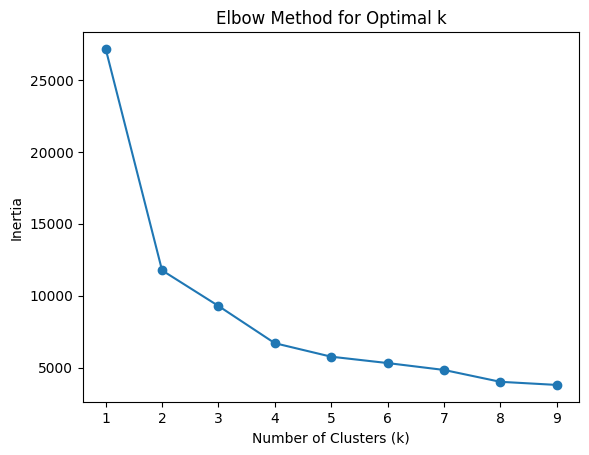

In [21]:
# Calculate inertia for different values of k
inertia = []
for k in range(1, 10):
  kmeans = KMeans(n_clusters=k, random_state=0)
  kmeans.fit(rfm_scores)
  inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [22]:
# Choose the number of clusters (k)
kmeans = KMeans(n_clusters=4, random_state=0)

# Fit the K-means model to the RFM scores
kmeans.fit(rfm_scores)

# Add cluster labels to the DataFrame
rfm['Cluster'] = kmeans.labels_

# Now we have the RFM DataFrame 'rfm' with cluster labels.
rfm.head()


,CustomerID,R,F,M,Cluster
0,12346,1,1,5,1
1,12347,5,5,5,2
2,12348,2,4,4,1
3,12349,4,1,4,3
4,12350,1,1,2,0


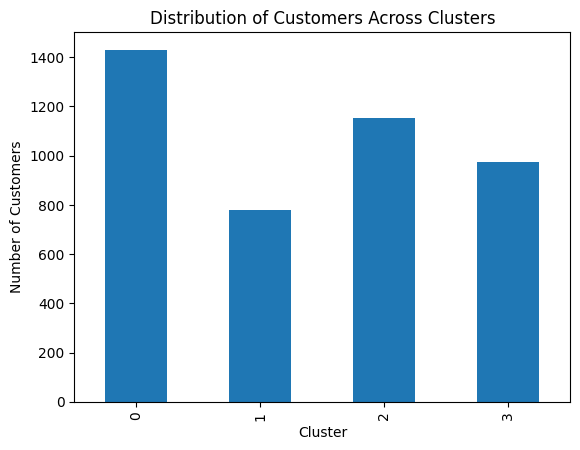

In [26]:
rfm.groupby('Cluster').size().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customers Across Clusters')
plt.show()
